In [1]:
%load_ext autoreload
%autoreload 2

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [2]:
%run ../notebooks/0_parameters.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
{'w': 28, 'minibatch_size': 100, 'train_batch_size': 50000, 'test_batch_size': 5000, 'noise_batch_size': 1000, 'mean': 0.1307, 'std': 0.3081, 'N_pic': 128, 'offset_std': 30, 'offset_max': 34, 'noise': 1.0, 'contrast': 1.0, 'sf_0': 0.2, 'B_sf': 0.3, 'N_theta': 6, 'N_azimuth': 26, 'N_eccentricity': 10, 'N_phase': 2, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.0, 'dim1': 500, 'dim2': 2000, 'lr': 0.001, 'do_adam': True, 'bn1_bn_momentum': 0.5, 'bn2_bn_momentum': 0.2, 'momentum': 0.1, 'epochs': 25, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-03-27', 'seed': 2019, 'N_cv': 8, 'do_compute': True}
Overwriting train.py
2020-01-24T11:22:20+01:00

CPython 3.7.6
IPython 7.11.1

numpy 1.18.1
matplotlib 

In [3]:
figname = '../figures/fig_intro'

# A/ process generating display images

In [4]:
from display import Display
d = Display(args)
data, label = next(iter(d.loader_test))

In [5]:
print('data.shape=', data.shape)

data.shape= torch.Size([5000, 1, 28, 28])


## placing the digits in some random noise

In [6]:
from display import minmax, place_object

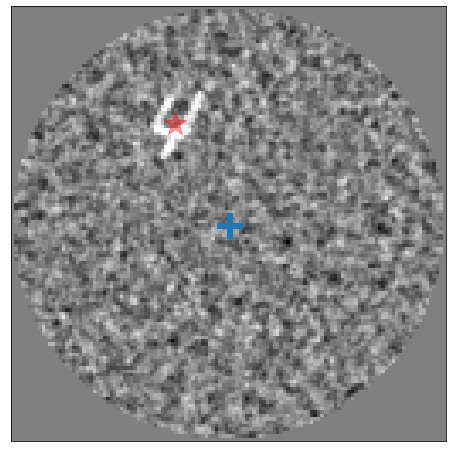

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
i_ax = 0
idx = 4
i_offset, j_offset = -30, -16
#data_fullfield, i_offset, j_offset = d.draw(data[i_ax, 0, :, :].numpy())
data_fullfield = d.place_object(data[idx, 0, :, :].numpy(), i_offset, j_offset)
ax = d.show(ax, data_fullfield, do_cross=True)
ax.plot([args.N_pic//2+j_offset], [args.N_pic//2+i_offset], '*r', ms=24, markeredgewidth=1, alpha=.4)

fig.savefig('../dev/2020-01-23_where-display.svg')

# C/ foveation

In [8]:
from retina import Retina
r = Retina(args)

In [9]:
data_retina = r.retina(data_fullfield)
do_dewhitening = True
im = r.retina_invert(data_retina, do_dewhitening=do_dewhitening)

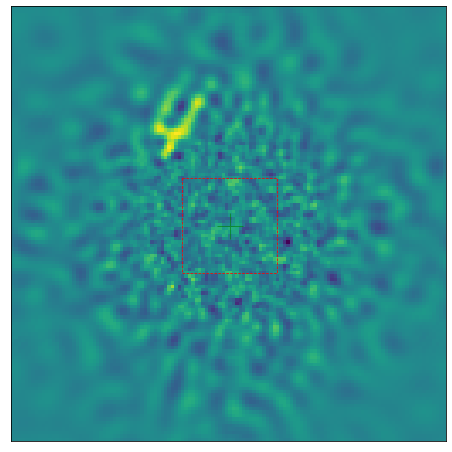

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
ax = r.show(ax, im, rmin=im.min(), rmax=im.max())
fig.savefig('../dev/2020-01-23_where-display_rec.svg')

## Representation of output accuracy (colliculus)

In [11]:
path = "../data/MNIST_accuracy.npy"
if os.path.isfile(path):
    accuracy_map =  np.load(path)
    if args.verbose:
        print('Loading accuracy... min, max=', accuracy_map.min(), accuracy_map.max())
else:
    print('No accuracy data found.')

Loading accuracy... min, max= 0.0145 0.9852


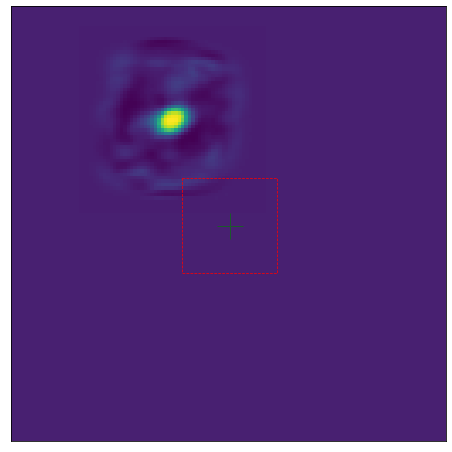

In [12]:
accuracy_colliculus, accuracy_fullfield_map = r.accuracy_fullfield(accuracy_map, i_offset, j_offset)

fig, ax = plt.subplots(1, 1, figsize = (8, 8))
im = accuracy_fullfield_map
ax = r.show(ax, im, rmin=im.min(), rmax=im.max())
#ax.imshow(accuracy_fullfield_map, vmin=0, vmax=1, cmap=plt.plasma())
fig.savefig('../dev/2020-01-23_where-accuracy-full.svg')

In [13]:
from main import init
args = init(filename='../data/2019-04-16')

from where import Where
from what import WhatNet
where = Where(args)

filename_train = args.filename + '_train.pt'
#where.train(filename_train)

/usr/local/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'what.WhatNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patch

loading model
Loading training dataset
Loading testing dataset


In [14]:
positions, data_fullfield, retina_data, accuracy_colliculus = where.minibatch(data_fullfield)

In [15]:
accuracy_colliculus

tensor([[0.0778, 0.0759, 0.0702,  ..., 0.1101, 0.1025, 0.1010],
        [0.0999, 0.0999, 0.0999,  ..., 0.0995, 0.0999, 0.1001],
        [0.1000, 0.1000, 0.1000,  ..., 0.0998, 0.1000, 0.1000],
        ...,
        [0.0984, 0.0980, 0.0983,  ..., 0.0988, 0.0999, 0.1002],
        [0.0994, 0.0986, 0.0948,  ..., 0.1878, 0.1354, 0.1083],
        [0.1583, 0.1642, 0.1642,  ..., 0.1474, 0.1089, 0.1017]])

Text(0.5, 1.05, 'True')

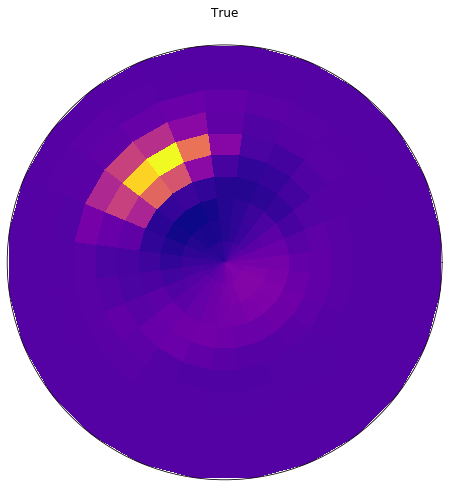

In [16]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='polar')
ax.pcolor(where.retina.theta_grid, where.retina.log_r_grid, accuracy_colliculus[idx, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("True")
#fig.savefig('../dev/2020-01-23_where-accuracy-rec.svg')

In [17]:
pred_accuracy_colliculus = where.pred_accuracy(retina_data)
print('pred_accuracy_colliculus.shape=', pred_accuracy_colliculus.shape)

pred_accuracy_colliculus.shape= (100, 240)


Text(0.5, 1.05, 'Predicted')

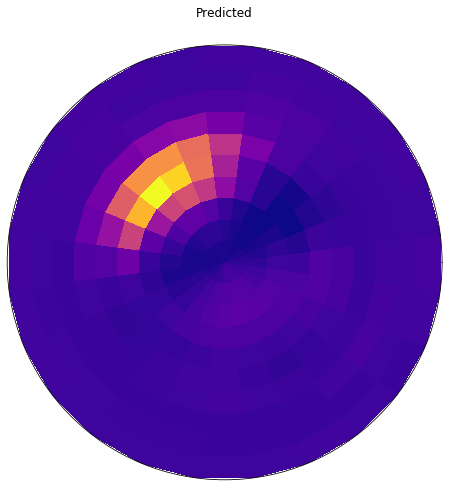

In [18]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='polar')
ax.pcolor(where.retina.theta_grid, where.retina.log_r_grid, pred_accuracy_colliculus[idx, :].reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_title("Predicted")

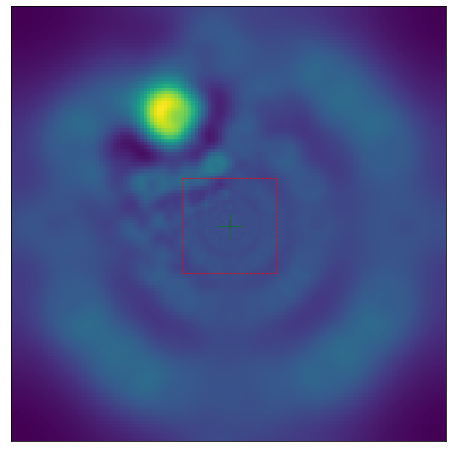

In [19]:
accuracy_colliculus, accuracy_fullfield_map = r.accuracy_fullfield(accuracy_map, i_offset, j_offset)

fig, ax = plt.subplots(1, 1, figsize = (8, 8))
im = r.accuracy_invert(accuracy_colliculus)
ax = r.show(ax, im, rmin=im.min(), rmax=im.max())
fig.savefig('../dev/2020-01-23_where-accuracy-rec.svg')